In [76]:
# oppress all warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [77]:
# avoidn unnecessary zeros
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import io
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
from geopy.geocoders import Nominatim
from time import sleep
from datetime import datetime
from pandas.api.types import CategoricalDtype
from pandas.api.types import CategoricalDtype

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=1.0)
import seaborn as sns

# Load data

In [79]:
# read hourly volume
hr_vol2=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/eco_hourly_clean_volume.csv')
# read permanent counters data afte QA and QC check
Permanent_counter=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/permanent_counter_2019_2016_AADBT_data.csv')

In [80]:
# Select the useable permanent counters only
ami=pd.merge(hr_vol2,Permanent_counter,left_on=['ID','year'],right_on=['ID','year'],how='inner')
ami.head()

,Unnamed: 0_x,index,ID,year,month,day,weekno,dayofweek,weekday_Status,starttime,...,location_x,location_y,Flag,Unnamed: 0_y,location,latitude_y,longitude_y,ATT,no_of_months_data_collected,type
0,7,7,671,2016,1,1,53,4,0,07:00:00,...,urban,urban,0,0,urban,37.79,-122.46,19573.00,12,eco_permanent
1,31,31,671,2016,1,2,53,5,1,07:00:00,...,urban,urban,0,0,urban,37.79,-122.46,19573.00,12,eco_permanent
2,55,55,671,2016,1,3,53,6,1,07:00:00,...,urban,urban,0,0,urban,37.79,-122.46,19573.00,12,eco_permanent
3,79,79,671,2016,1,4,1,0,0,07:00:00,...,urban,urban,0,0,urban,37.79,-122.46,19573.00,12,eco_permanent
4,103,103,671,2016,1,5,1,1,0,07:00:00,...,urban,urban,0,0,urban,37.79,-122.46,19573.00,12,eco_permanent


# Calculate indices permanent counters

## AMI

The AM to midday index (AMI) is the ratio of the average weekday volume observed between 7 and 9 am to the average weekday volume between 11 am and 1 pm. 

In [ ]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
ami['Day of Week'] = ami['Day of Week'].astype(cat_type)

In [82]:
# Calculate AM Count by eco id
df181am1=ami[(ami['starttime']=='07:00:00')]
df181am2=ami[(ami['starttime']=='08:00:00')]
df181am=pd.concat([df181am1,df181am2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181amg=pd.DataFrame({'AM_count' : df181am.groupby(['ID','year','Day of Week','Week Day Status'])['counts'].sum()}).reset_index()

# Calculate pM count by Eco ID
df181pm1=ami[(ami['starttime']=='11:00:00')]
df181pm2=ami[(ami['starttime']=='12:00:00')]
df181pm=pd.concat([df181pm1,df181pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'PM_count' : df181pm.groupby(['ID','year','Day of Week','Week Day Status'])['counts'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_am_pm=pd.merge(df181amg,df181pmg,left_on=['ID','year','Day of Week','Week Day Status'],right_on=['ID','year','Day of Week','Week Day Status'],how='inner')
# Calculate the AMI
df181_am_pm['AMI']=df181_am_pm['AM_count']/df181_am_pm['PM_count']
df181_am_pm.head()

,ID,year,Day of Week,Week Day Status,AM_count,PM_count,AMI
0,671,2016,Monday,Week Day,171.00,383.00,0.45
1,671,2016,Monday,Weekend,0.00,0.00,NaN
2,671,2016,Tuesday,Week Day,282.00,303.00,0.93
3,671,2016,Tuesday,Weekend,0.00,0.00,NaN
4,671,2016,Wednesday,Week Day,266.00,300.00,0.89


In [83]:
# exclude some of the anomally
df181_am_pm=df181_am_pm.loc[df181_am_pm['AMI']<10]
df181_am_pm.head()

,ID,year,Day of Week,Week Day Status,AM_count,PM_count,AMI
0,671,2016,Monday,Week Day,171.00,383.00,0.45
2,671,2016,Tuesday,Week Day,282.00,303.00,0.93
4,671,2016,Wednesday,Week Day,266.00,300.00,0.89
6,671,2016,Thursday,Week Day,260.00,335.00,0.78
8,671,2016,Friday,Week Day,208.00,437.00,0.48


In [84]:
# Calculate daily max AMI
Daily_AMI_max=pd.DataFrame({'Daily_Max_AMI' : df181_am_pm.groupby(['ID','year'])['AMI'].max()}).reset_index()
Daily_AMI_max.head()

,ID,year,Daily_Max_AMI
0,671,2016,0.93
1,671,2017,1.02
2,671,2018,1.43
3,671,2019,1.21
4,1127,2016,2.24


In [85]:
# Calculate max AMI
AMI_max=pd.DataFrame({'Max_AMI' : df181_am_pm.groupby(['ID','year','Week Day Status'])['AMI'].max()}).reset_index()
AMI_max.head()

,ID,year,Week Day Status,Max_AMI
0,671,2016,Week Day,0.93
1,671,2016,Weekend,0.36
2,671,2017,Week Day,1.02
3,671,2017,Weekend,0.44
4,671,2018,Week Day,1.43


In [86]:
# Calculate max weekday AMI
Weekday_AMI_max=AMI_max.loc[AMI_max['Week Day Status']=='Week Day']
Weekday_AMI_max=Weekday_AMI_max.rename(columns={'Max_AMI':'Max_weekday_AMI'})
Weekday_AMI_max=Weekday_AMI_max[['ID','year','Max_weekday_AMI']]
Weekday_AMI_max.head()

,ID,year,Max_weekday_AMI
0,671,2016,0.93
2,671,2017,1.02
4,671,2018,1.43
6,671,2019,1.21
8,1127,2016,2.24


In [87]:
# calculate max weekend AMI
Weekend_AMI_max=AMI_max.loc[AMI_max['Week Day Status']=='Weekend']
Weekend_AMI_max=Weekend_AMI_max.rename(columns={'Max_AMI':'Max_weekend_AMI'})
Weekend_AMI_max=Weekend_AMI_max[['ID','year','Max_weekend_AMI']]
Weekend_AMI_max.head()

,ID,year,Max_weekend_AMI
1,671,2016,0.36
3,671,2017,0.44
5,671,2018,0.30
7,671,2019,0.35
9,1127,2016,0.74


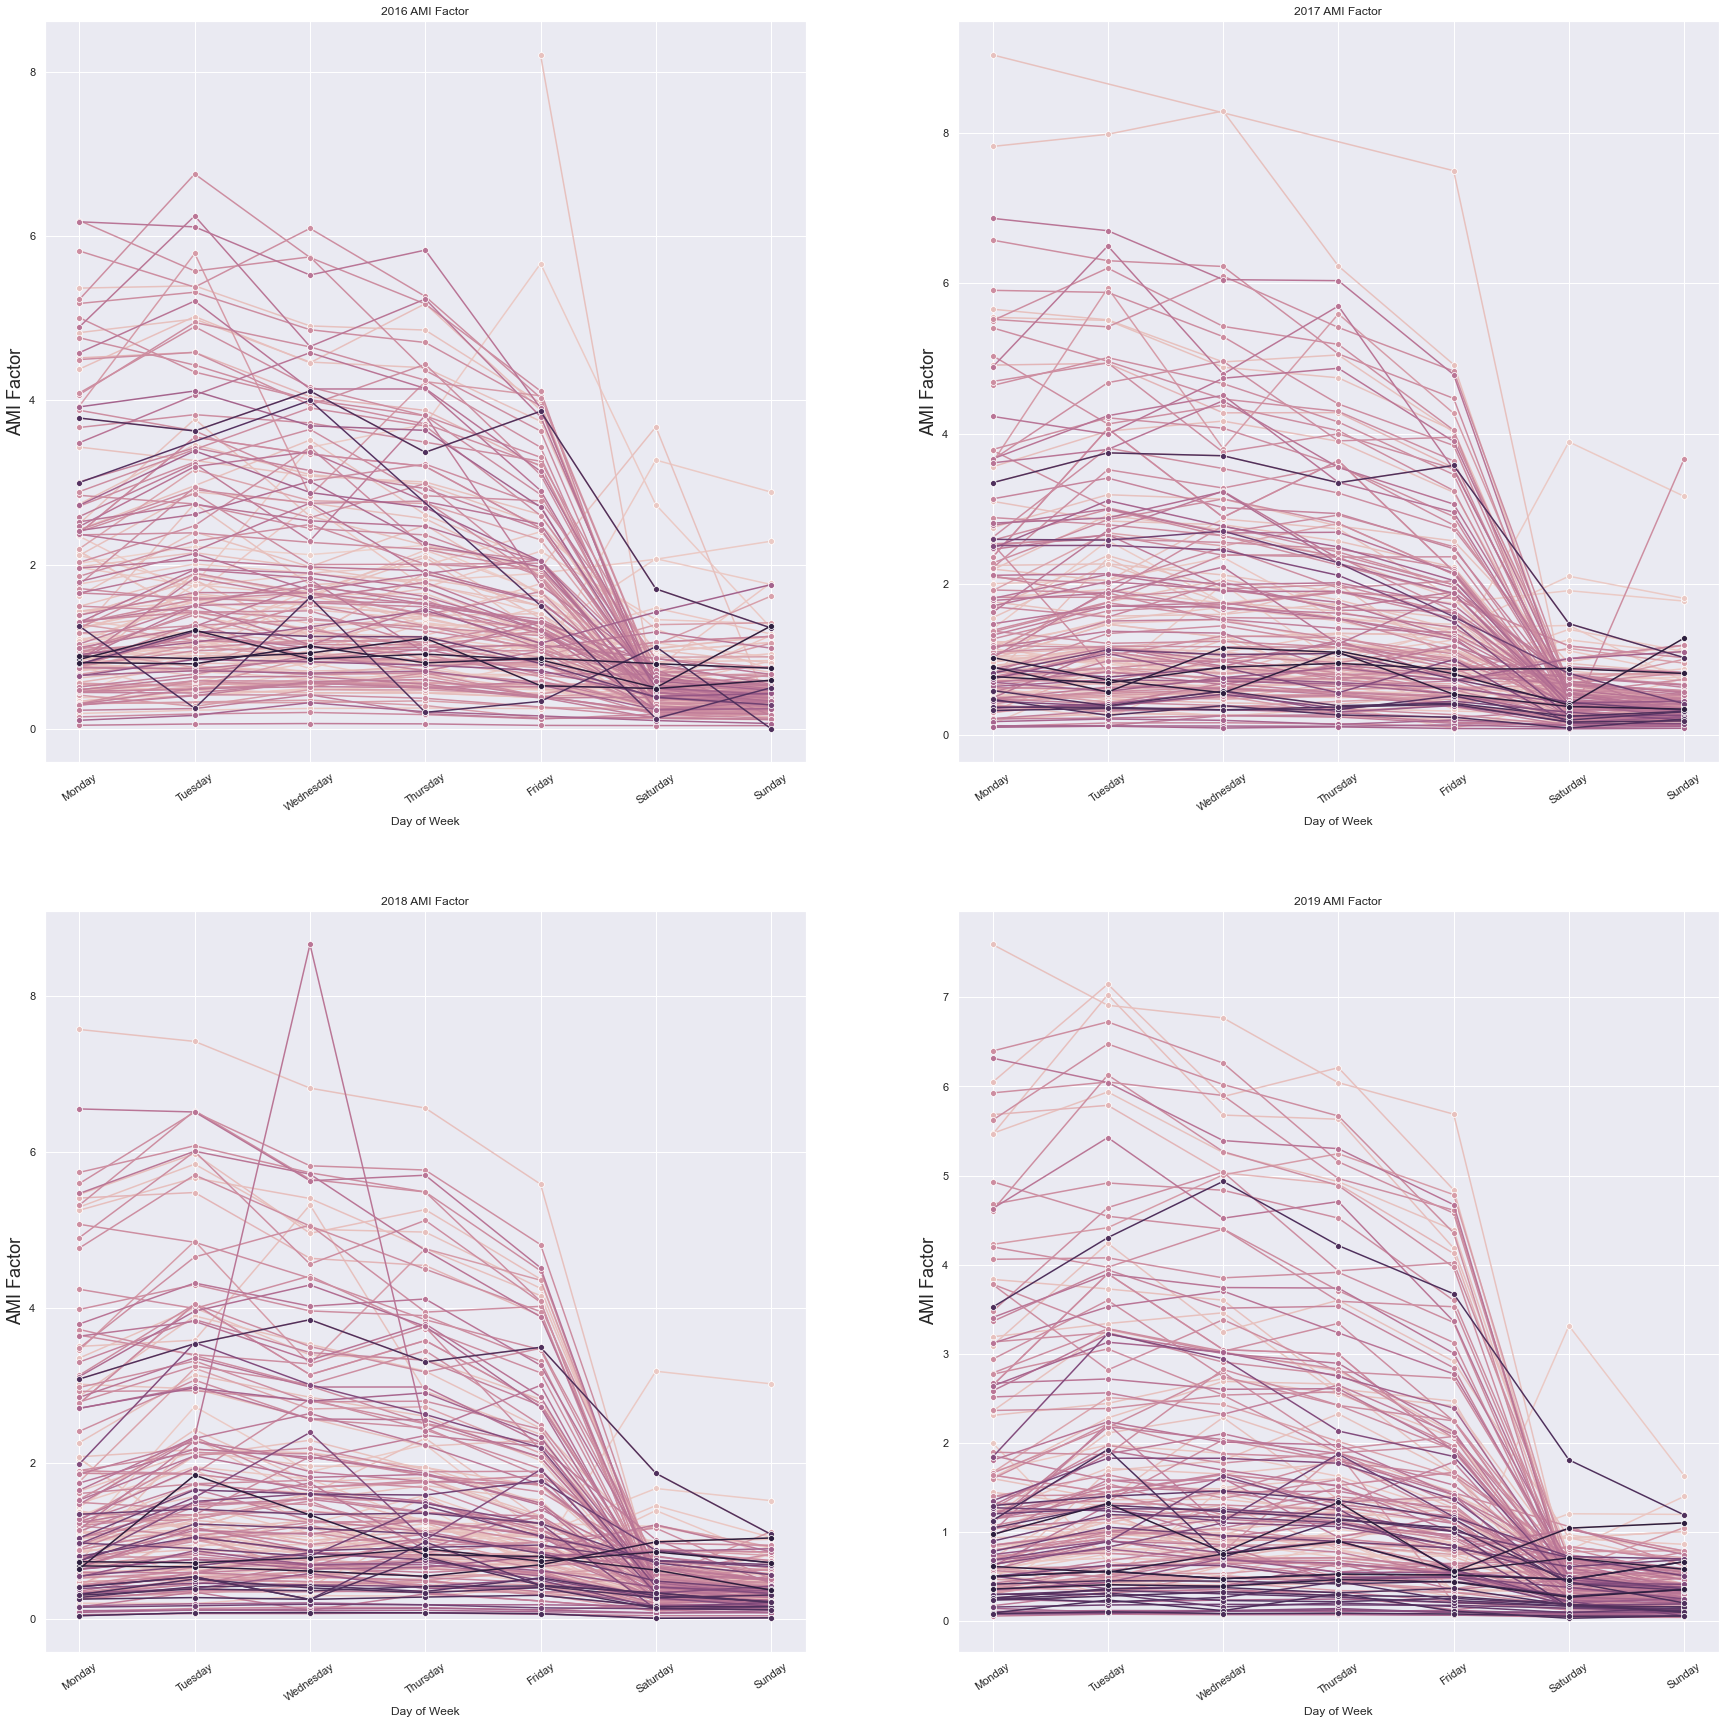

In [ ]:

ami16=df181_am_pm.loc[df181_am_pm['year']==2016]
ami17=df181_am_pm.loc[df181_am_pm['year']==2017]
ami18=df181_am_pm.loc[df181_am_pm['year']==2018]
ami19=df181_am_pm.loc[df181_am_pm['year']==2019]


fig, ax = plt.subplots(2,2)

ax1 = sns.lineplot(x=ami16['Day of Week'],y=ami16['AMI'],hue=ami16['ID'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.lineplot(x=ami17['Day of Week'],y=ami17['AMI'],hue=ami17['ID'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.lineplot(x=ami18['Day of Week'],y=ami18['AMI'],hue=ami18['ID'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.lineplot(x=ami19['Day of Week'],y=ami19['AMI'],hue=ami19['ID'],
                   markers=True, marker="o", dashes=False,sort=True,ax=ax[1,1]) 
plt.xticks(rotation = 'vertical')
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax1.title.set_text('2016 AMI Factor')
ax2.title.set_text('2017 AMI Factor')
ax3.title.set_text('2018 AMI Factor')
ax4.title.set_text('2019 AMI Factor')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=35)
ax1.set_ylabel('AMI Factor',fontsize=18)
ax1.set_xlabel('Day of Week')
ax2.set_ylabel('AMI Factor',fontsize=18 )
ax2.set_xlabel('Day of Week')
ax3.set_ylabel('AMI Factor',fontsize=18 )
ax3.set_xlabel('Day of Week')
ax4.set_ylabel('AMI Factor',fontsize=18 )
ax4.set_xlabel('Day of Week')
plt.show()

In [89]:
# Calculate Average weekday, weekend AMI and its ratio
AMI_Ave=pd.DataFrame({'Aergage_AMI' : df181_am_pm.groupby(['ID','year','Week Day Status'])['AMI'].mean()}).reset_index()
AMI_Ave_weekday=AMI_Ave.loc[AMI_Ave['Week Day Status']=='Week Day']
AMI_Ave_weekday=AMI_Ave_weekday.rename(columns={'Aergage_AMI':'Weekday_Aergage_AMI'})
AMI_Ave_weekend=AMI_Ave.loc[AMI_Ave['Week Day Status']=='Weekend']
AMI_Ave_weekend=AMI_Ave_weekend.rename(columns={'Aergage_AMI':'Weekend_Aergage_AMI'})
AMI_ratio=pd.merge(AMI_Ave_weekday,AMI_Ave_weekend,left_on=['ID','year'],right_on=['ID','year'],how='inner')
AMI_ratio['Average AMI_wday_wend']=AMI_ratio['Weekday_Aergage_AMI']/AMI_ratio['Weekend_Aergage_AMI']
AMI_ratio.head()

,ID,year,Week Day Status_x,Weekday_Aergage_AMI,Week Day Status_y,Weekend_Aergage_AMI,Average AMI_wday_wend
0,671,2016,Week Day,0.70,Weekend,0.32,2.17
1,671,2017,Week Day,0.74,Weekend,0.38,1.97
2,671,2018,Week Day,0.86,Weekend,0.29,2.97
3,671,2019,Week Day,0.82,Weekend,0.34,2.41
4,1127,2016,Week Day,2.05,Weekend,0.58,3.51


In [90]:
AMI_ratio1=AMI_ratio[['ID','year','Weekday_Aergage_AMI','Weekend_Aergage_AMI','Average AMI_wday_wend']]
AMI_ratio1.shape

(695, 5)

In [91]:
# combined AMI indices
all_AMI_indices=pd.merge(AMI_ratio1,Weekend_AMI_max,left_on=['ID','year'],right_on=['ID','year'],how='outer')
all_AMI_indices1=pd.merge(all_AMI_indices,Weekday_AMI_max,left_on=['ID','year'],right_on=['ID','year'],how='outer')
all_AMI_indices2=pd.merge(all_AMI_indices1,Daily_AMI_max,left_on=['ID','year'],right_on=['ID','year'],how='outer')
all_AMI_indices2.head()

,ID,year,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,Daily_Max_AMI
0,671,2016,0.70,0.32,2.17,0.36,0.93,0.93
1,671,2017,0.74,0.38,1.97,0.44,1.02,1.02
2,671,2018,0.86,0.29,2.97,0.30,1.43,1.43
3,671,2019,0.82,0.34,2.41,0.35,1.21,1.21
4,1127,2016,2.05,0.58,3.51,0.74,2.24,2.24


## PMI 

The PM to midday index (PMI) is the ratio of the average weekday volume observed between 5 pm and 7 pm to the average weekday volume observed between 11 am and 1 pm.

In [92]:
# Calculate AM Count by eco id
df181pm1=ami[(ami['starttime']=='17:00:00')]
df181pm2=ami[(ami['starttime']=='18:00:00')]
df181pm=pd.concat([df181pm1,df181pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'late_PM_count' : df181pm.groupby(['ID','year','Day of Week','Week Day Status'])['counts'].sum()}).reset_index()

# Calculate pM count by Eco ID
df181pm2g1=ami[(ami['starttime']=='11:00:00')]
df181pm2g2=ami[(ami['starttime']=='12:00:00')]
df181pm2g=pd.concat([df181pm2g1,df181pm2g2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pm2g=pd.DataFrame({'early_PM_count' : df181pm2g.groupby(['ID','year','Day of Week','Week Day Status'])['counts'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_pm_pm=pd.merge(df181pmg,df181pm2g,left_on=['ID','year','Day of Week','Week Day Status'],right_on=['ID','year','Day of Week','Week Day Status'],how='inner')
# Calculate the AMI
df181_pm_pm['PMI']=df181_pm_pm['late_PM_count']/df181_pm_pm['early_PM_count']
df181_pm_pm.head()

,ID,year,Day of Week,Week Day Status,late_PM_count,early_PM_count,PMI
0,671,2016,Monday,Week Day,326.00,383.00,0.85
1,671,2016,Monday,Weekend,0.00,0.00,NaN
2,671,2016,Tuesday,Week Day,352.00,303.00,1.16
3,671,2016,Tuesday,Weekend,0.00,0.00,NaN
4,671,2016,Wednesday,Week Day,368.00,300.00,1.23


In [93]:
# calculate daily Max PMI
Daily_PMI_max=pd.DataFrame({'Daily_Max_PMI' : df181_pm_pm.groupby(['ID','year'])['PMI'].max()}).reset_index()
Daily_PMI_max.head()

,ID,year,Daily_Max_PMI
0,671,2016,1.23
1,671,2017,1.21
2,671,2018,1.30
3,671,2019,1.13
4,1127,2016,0.91


In [94]:
# Calculate Max Weekend PMI
PMI_max=pd.DataFrame({'Max_PMI' : df181_pm_pm.groupby(['ID','year','Week Day Status'])['PMI'].max()}).reset_index()
Weekday_PMI_max=PMI_max.loc[PMI_max['Week Day Status']=='Week Day']
Weekday_PMI_max=Weekday_PMI_max.rename(columns={'Max_PMI':'Max_weekday_PMI'})
Weekday_PMI_max=Weekday_PMI_max[['ID','year','Max_weekday_PMI']]

Weekend_PMI_max=PMI_max.loc[PMI_max['Week Day Status']=='Weekend']
Weekend_PMI_max=Weekend_PMI_max.rename(columns={'Max_PMI':'Max_weekend_PMI'})
Weekend_PMI_max=Weekend_PMI_max[['ID','year','Max_weekend_PMI']]
Weekend_PMI_max.head()

,ID,year,Max_weekend_PMI
1,671,2016,0.49
3,671,2017,0.49
5,671,2018,0.39
7,671,2019,0.42
9,1127,2016,0.91


In [95]:
# calculate weekday, weekend average PMI and its ratio
PMI_Ave=pd.DataFrame({'Aergage_PMI' : df181_pm_pm.groupby(['ID','year','Week Day Status'])['PMI'].mean()}).reset_index()
PMI_Ave_weekday=PMI_Ave.loc[PMI_Ave['Week Day Status']=='Week Day']
PMI_Ave_weekday=PMI_Ave_weekday.rename(columns={'Aergage_PMI':'Weekday_Aergage_PMI'})
PMI_Ave_weekend=PMI_Ave.loc[PMI_Ave['Week Day Status']=='Weekend']
PMI_Ave_weekend=PMI_Ave_weekend.rename(columns={'Aergage_PMI':'Weekend_Aergage_PMI'})
PMI_ratio=pd.merge(PMI_Ave_weekday,PMI_Ave_weekend,left_on=['ID','year'],right_on=['ID','year'],how='inner')
PMI_ratio['Average PMI_wday_wend']=PMI_ratio['Weekday_Aergage_PMI']/PMI_ratio['Weekend_Aergage_PMI']
PMI_ratio=PMI_ratio[['ID','year','Weekday_Aergage_PMI','Weekend_Aergage_PMI','Average PMI_wday_wend']]
PMI_ratio.head()

,ID,year,Weekday_Aergage_PMI,Weekend_Aergage_PMI,Average PMI_wday_wend
0,671,2016,1.01,0.46,2.21
1,671,2017,0.97,0.47,2.07
2,671,2018,0.99,0.36,2.73
3,671,2019,0.98,0.38,2.56
4,1127,2016,0.74,0.83,0.89


In [96]:
# combine all PMI Indices
PMI1=pd.merge(Daily_PMI_max,PMI_ratio,left_on=["ID",'year'],right_on=["ID",'year'], how='outer')
PMI2=pd.merge(Weekday_PMI_max,Weekend_PMI_max,left_on=["ID",'year'],right_on=["ID",'year'], how='outer')
PMI=pd.merge(PMI1,PMI2,left_on=["ID",'year'],right_on=["ID",'year'], how='outer')
PMI.head()

,ID,year,Daily_Max_PMI,Weekday_Aergage_PMI,Weekend_Aergage_PMI,Average PMI_wday_wend,Max_weekday_PMI,Max_weekend_PMI
0,671,2016,1.23,1.01,0.46,2.21,1.23,0.49
1,671,2017,1.21,0.97,0.47,2.07,1.21,0.49
2,671,2018,1.30,0.99,0.36,2.73,1.30,0.39
3,671,2019,1.13,0.98,0.38,2.56,1.13,0.42
4,1127,2016,0.91,0.74,0.83,0.89,0.78,0.91


In [97]:
# combine AMI and PMI indices together
AMI_PMI=pd.merge(all_AMI_indices2,PMI,left_on=["ID",'year'],right_on=["ID",'year'], how='inner')
AMI_PMI.head()

,ID,year,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,Daily_Max_AMI,Daily_Max_PMI,Weekday_Aergage_PMI,Weekend_Aergage_PMI,Average PMI_wday_wend,Max_weekday_PMI,Max_weekend_PMI
0,671,2016,0.70,0.32,2.17,0.36,0.93,0.93,1.23,1.01,0.46,2.21,1.23,0.49
1,671,2017,0.74,0.38,1.97,0.44,1.02,1.02,1.21,0.97,0.47,2.07,1.21,0.49
2,671,2018,0.86,0.29,2.97,0.30,1.43,1.43,1.30,0.99,0.36,2.73,1.30,0.39
3,671,2019,0.82,0.34,2.41,0.35,1.21,1.21,1.13,0.98,0.38,2.56,1.13,0.42
4,1127,2016,2.05,0.58,3.51,0.74,2.24,2.24,0.91,0.74,0.83,0.89,0.78,0.91


In [98]:
# define Function to calculate Max indices value
def max(Daily_Max_AMI,Daily_Max_PMI):
    if Daily_Max_AMI>Daily_Max_PMI:
        return 'AM'
    else:
        return 'PM'
def max_value(Daily_Max_AMI,Daily_Max_PMI):
    if Daily_Max_AMI>Daily_Max_PMI:
        return Daily_Max_AMI
    else:
        return Daily_Max_PMI
    

def max_weekend(Max_weekend_AMI,Max_weekend_PMI):
    if Max_weekend_AMI>Max_weekend_PMI:
        return 'AMI'
    else:
        return 'PMI'
    
def max_weekend_value(Max_weekend_AMI,Max_weekend_PMI):
    if Max_weekend_AMI>Max_weekend_PMI:
        return Max_weekend_AMI
    else:
        return Max_weekend_PMI
    
def max_weekday(Max_weekday_AMI,Max_weekday_PMI):
    if Max_weekday_AMI>Max_weekday_PMI:
        return 'AMI'
    else:
        return 'PMI'
    
def max_weekday_value(Max_weekday_AMI,Max_weekday_PMI):
    if Max_weekday_AMI>Max_weekday_PMI:
        return Max_weekday_AMI
    else:
        return Max_weekday_PMI

In [99]:
AMI_PMI['max_daily_am_pm']=AMI_PMI.apply(lambda row:max(row['Daily_Max_AMI'],row['Daily_Max_PMI']),axis=1)
AMI_PMI['max_daily_am_pm_value']=AMI_PMI.apply(lambda row:max_value(row['Daily_Max_AMI'],row['Daily_Max_PMI']),axis=1)
AMI_PMI['max_weekend_am_pm']=AMI_PMI.apply(lambda row:max_weekend(row['Max_weekend_AMI'],row['Max_weekend_PMI']),axis=1)
AMI_PMI['max_weekend_am_pm_Value']=AMI_PMI.apply(lambda row:max_weekend_value(row['Max_weekend_AMI'],row['Max_weekend_PMI']),axis=1)
AMI_PMI['max_weekday_am_pm']=AMI_PMI.apply(lambda row:max_weekday(row['Max_weekday_AMI'],row['Max_weekday_PMI']),axis=1)
AMI_PMI['max_weekday_am_pm_value']=AMI_PMI.apply(lambda row:max_weekday_value(row['Max_weekday_AMI'],row['Max_weekday_PMI']),axis=1)
AMI_PMI.head()

,ID,year,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,Daily_Max_AMI,Daily_Max_PMI,Weekday_Aergage_PMI,Weekend_Aergage_PMI,Average PMI_wday_wend,Max_weekday_PMI,Max_weekend_PMI,max_daily_am_pm,max_daily_am_pm_value,max_weekend_am_pm,max_weekend_am_pm_Value,max_weekday_am_pm,max_weekday_am_pm_value
0,671,2016,0.70,0.32,2.17,0.36,0.93,0.93,1.23,1.01,0.46,2.21,1.23,0.49,PM,1.23,PMI,0.49,PMI,1.23
1,671,2017,0.74,0.38,1.97,0.44,1.02,1.02,1.21,0.97,0.47,2.07,1.21,0.49,PM,1.21,PMI,0.49,PMI,1.21
2,671,2018,0.86,0.29,2.97,0.30,1.43,1.43,1.30,0.99,0.36,2.73,1.30,0.39,AM,1.43,PMI,0.39,AMI,1.43
3,671,2019,0.82,0.34,2.41,0.35,1.21,1.21,1.13,0.98,0.38,2.56,1.13,0.42,AM,1.21,PMI,0.42,AMI,1.21
4,1127,2016,2.05,0.58,3.51,0.74,2.24,2.24,0.91,0.74,0.83,0.89,0.78,0.91,AM,2.24,PMI,0.91,AMI,2.24


In [100]:
# check the shape of the data
AMI_PMI.shape

(695, 20)

## WWI

The weekend/weekday index (WWI) is the ratio of the average weekend daily traffic to a particular site's average weekday daily traffic.

In [101]:
# Calculate weekend Count by eco id
df181_weekend=ami.loc[ami['weekday_Status']==1]
#df181_weekendg=pd.DataFrame({'Weekend_count' : df181_weekend.groupby(['ID','year'])['counts'].sum()}).reset_index()

# Calculate weekday count by Eco ID
df181_weeekday=ami.loc[ami['weekday_Status']==0]
#df181_weekdayg=pd.DataFrame({'Weekday_count' : df181_weeekday.groupby(['ID','year'])['counts'].sum()}).reset_index()

# Join weekend and weekday count by eco id
#df181_weekend_weekday=pd.merge(df181_weekendg,df181_weekdayg,left_on=["ID",'year'],right_on=["ID",'year'],how='inner')
# Calculate the WWI
#df181_weekend_weekday['WWI']=df181_weekend_weekday['Weekend_count']/df181_weekend_weekday['Weekday_count']
#df181_weekend_weekday.head()

In [102]:
df181_weekendg1=pd.DataFrame({'Weekend_count1' : df181_weekend.groupby(['ID','year','weekno'])['counts'].sum()}).reset_index()
df181_weekdayg1=pd.DataFrame({'Weekday_count1' : df181_weeekday.groupby(['ID','year','weekno'])['counts'].sum()}).reset_index()
df181_weekend_weekday1=pd.merge(df181_weekendg1,df181_weekdayg1,left_on=["ID",'year','weekno'],right_on=["ID",'year','weekno'],how='inner')
df181_weekend_weekday1['weekly_WWI']=df181_weekend_weekday1['Weekend_count1']/df181_weekend_weekday1['Weekday_count1']
df181_weekend_weekday1.head()

,ID,year,weekno,Weekend_count1,Weekday_count1,weekly_WWI
0,671,2016,1,126.00,105.00,1.20
1,671,2016,2,81.00,118.00,0.69
2,671,2016,3,155.00,143.00,1.08
3,671,2016,4,203.00,131.00,1.55
4,671,2016,5,208.00,153.00,1.36


In [103]:
WWI_max=pd.DataFrame({'Max_WWI' : df181_weekend_weekday1.groupby(['ID','year'])['weekly_WWI'].max()}).reset_index()
WWI=pd.DataFrame({'Average_WWI' : df181_weekend_weekday1.groupby(['ID','year'])['weekly_WWI'].mean()}).reset_index()
all_wwi=pd.merge(WWI_max,WWI,left_on=["ID",'year'],right_on=["ID",'year'],how='inner')
all_wwi.head()

,ID,year,Max_WWI,Average_WWI
0,671,2016,2.23,0.77
1,671,2017,2.89,0.78
2,671,2018,1.35,0.71
3,671,2019,1.44,0.66
4,1127,2016,2.22,0.26


### Combine indices & Visualize

In [104]:
# combine AMI_PMI and WWI
AMI_PMI_WWI=pd.merge(all_wwi,AMI_PMI,left_on=["ID",'year'],right_on=["ID",'year'],how='inner')
AMI_PMI_WWI.head()

,ID,year,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,Daily_Max_AMI,...,Weekend_Aergage_PMI,Average PMI_wday_wend,Max_weekday_PMI,Max_weekend_PMI,max_daily_am_pm,max_daily_am_pm_value,max_weekend_am_pm,max_weekend_am_pm_Value,max_weekday_am_pm,max_weekday_am_pm_value
0,671,2016,2.23,0.77,0.70,0.32,2.17,0.36,0.93,0.93,...,0.46,2.21,1.23,0.49,PM,1.23,PMI,0.49,PMI,1.23
1,671,2017,2.89,0.78,0.74,0.38,1.97,0.44,1.02,1.02,...,0.47,2.07,1.21,0.49,PM,1.21,PMI,0.49,PMI,1.21
2,671,2018,1.35,0.71,0.86,0.29,2.97,0.30,1.43,1.43,...,0.36,2.73,1.30,0.39,AM,1.43,PMI,0.39,AMI,1.43
3,671,2019,1.44,0.66,0.82,0.34,2.41,0.35,1.21,1.21,...,0.38,2.56,1.13,0.42,AM,1.21,PMI,0.42,AMI,1.21
4,1127,2016,2.22,0.26,2.05,0.58,3.51,0.74,2.24,2.24,...,0.83,0.89,0.78,0.91,AM,2.24,PMI,0.91,AMI,2.24


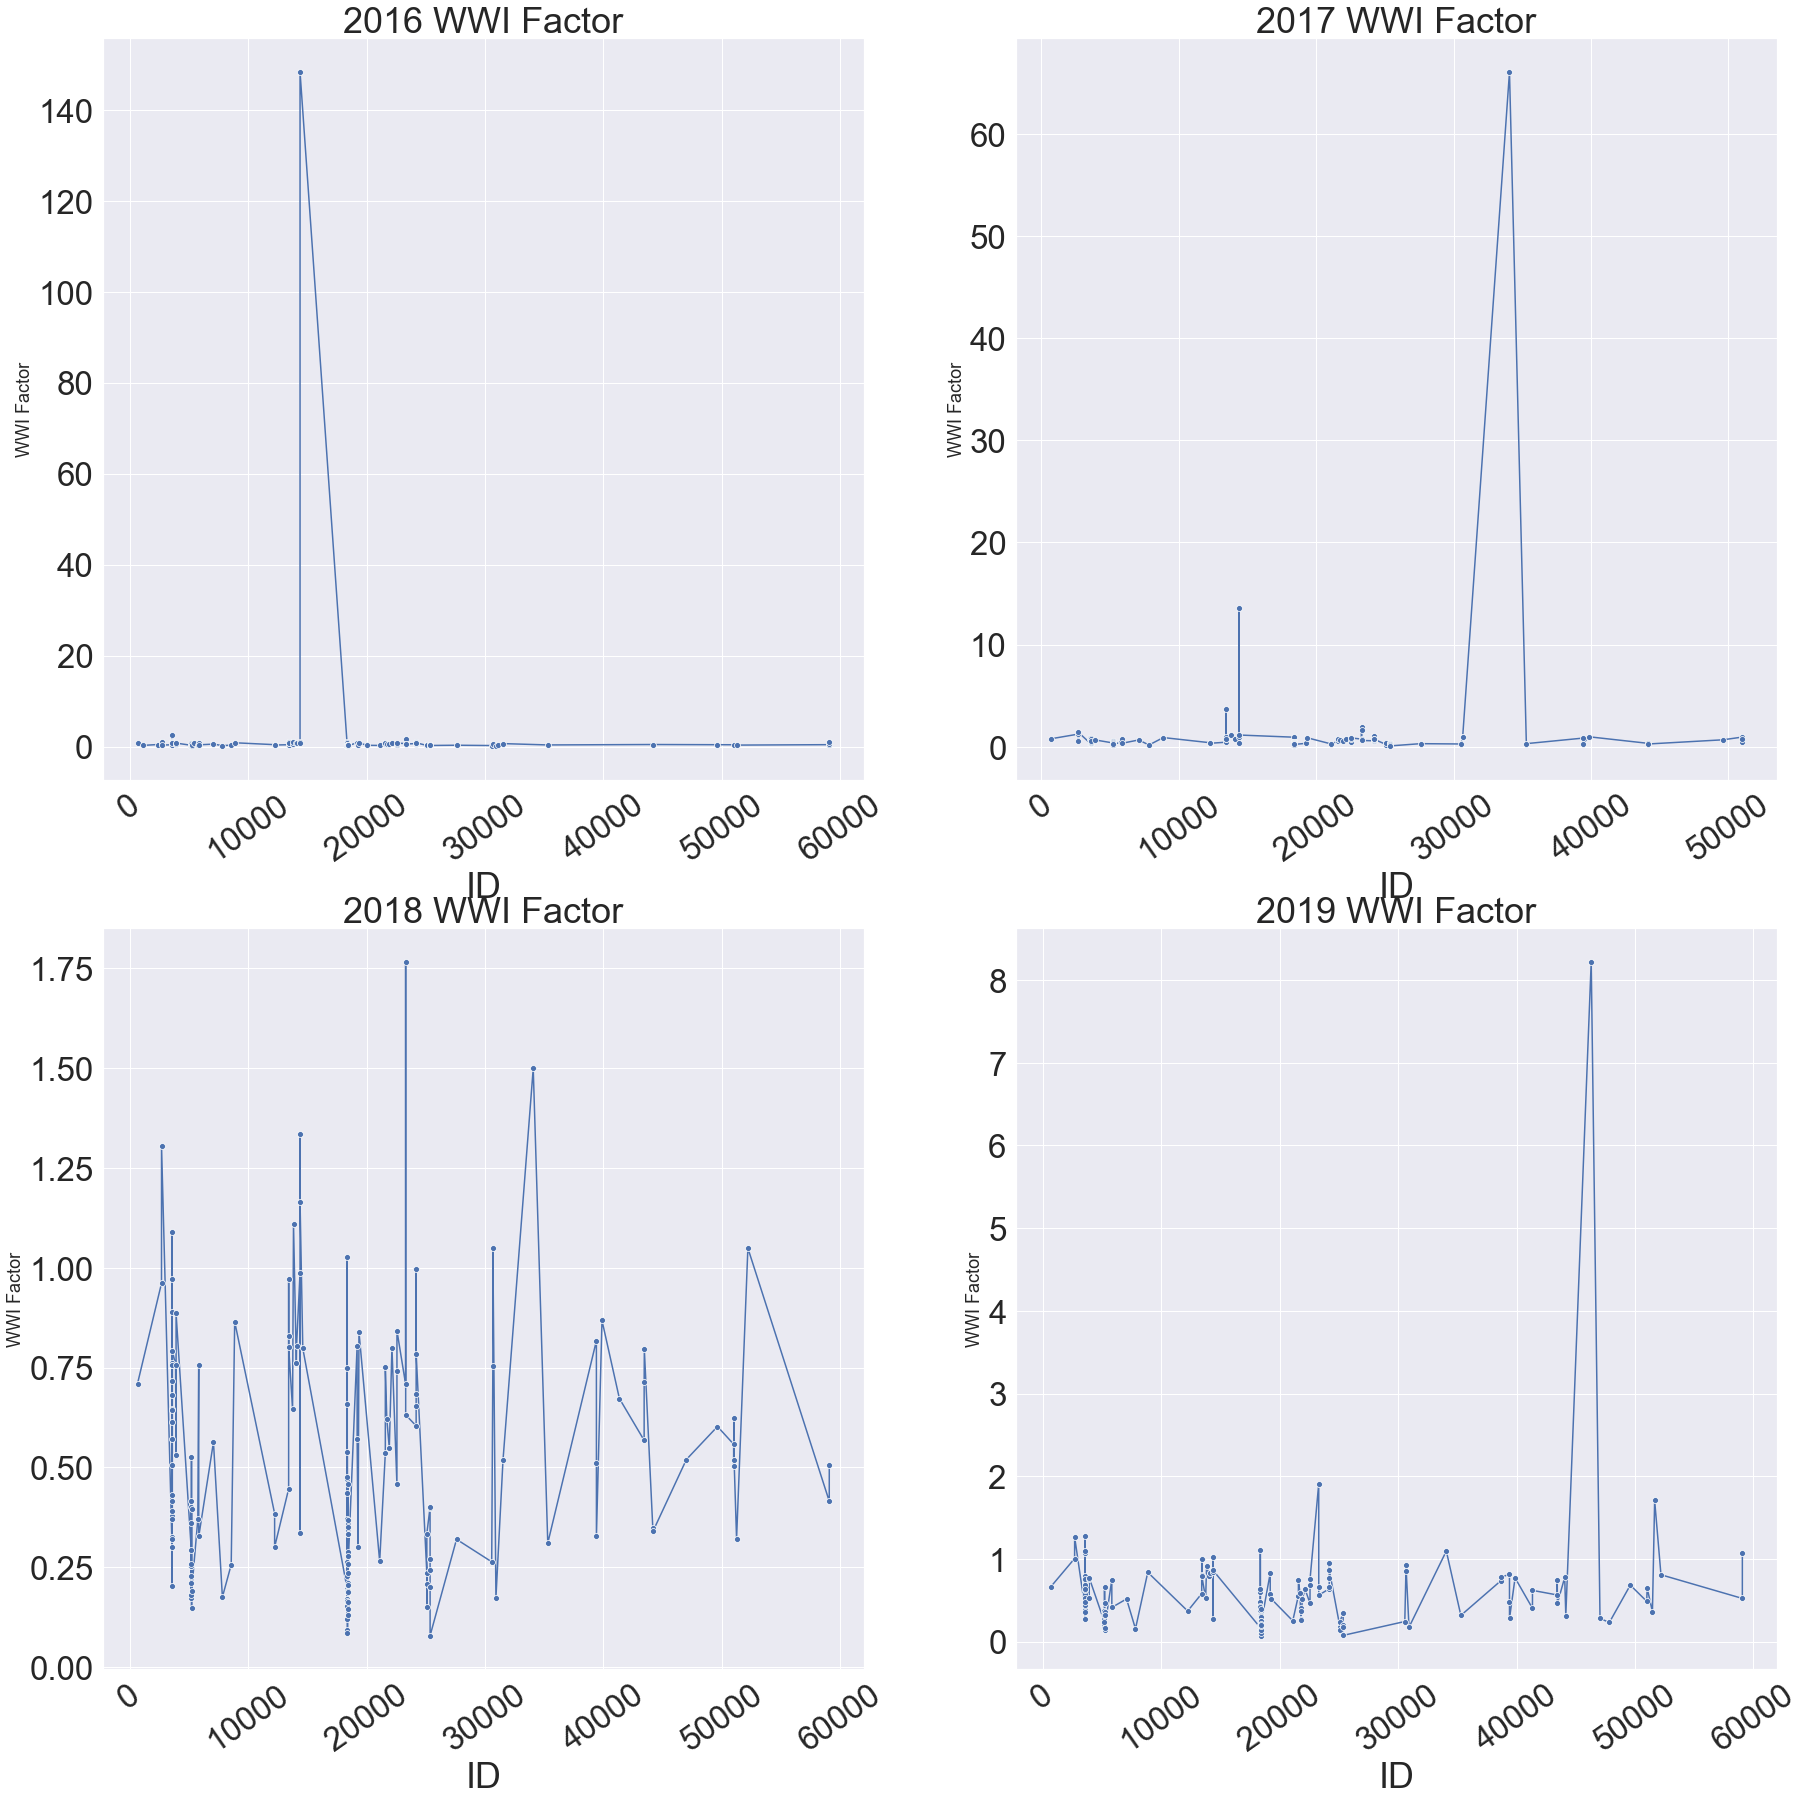

In [105]:
sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)
import seaborn as sns
ami16=AMI_PMI_WWI.loc[AMI_PMI_WWI['year']==2016]
ami17=AMI_PMI_WWI.loc[AMI_PMI_WWI['year']==2017]
ami18=AMI_PMI_WWI.loc[AMI_PMI_WWI['year']==2018]
ami19=AMI_PMI_WWI.loc[AMI_PMI_WWI['year']==2019]


fig, ax = plt.subplots(2,2)

ax1 = sns.lineplot(x=ami16['ID'],y=ami16['Average_WWI'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.lineplot(x=ami17['ID'],y=ami17['Average_WWI'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.lineplot(x=ami18['ID'],y=ami18['Average_WWI'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.lineplot(x=ami19['ID'],y=ami19['Average_WWI'],
                   markers=True, marker="o", dashes=False,sort=True,ax=ax[1,1]) 
plt.xticks(rotation = 'vertical')
#ax1.get_legend().remove()
#ax2.get_legend().remove()
#ax3.get_legend().remove()
#ax4.get_legend().remove()
ax1.title.set_text('2016 WWI Factor')
ax2.title.set_text('2017 WWI Factor')
ax3.title.set_text('2018 WWI Factor')
ax4.title.set_text('2019 WWI Factor')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=35)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=35)
ax1.set_ylabel('WWI Factor',fontsize=18)
ax1.set_xlabel('ID')
ax2.set_ylabel('WWI Factor',fontsize=18 )
ax2.set_xlabel('ID')
ax3.set_ylabel('WWI Factor',fontsize=18 )
ax3.set_xlabel('ID')
ax4.set_ylabel('WWI Factor',fontsize=18 )
ax4.set_xlabel('ID')
plt.show()

## SF

Seasonal Factor (SF): This study created seasonal factors by dividing the average daily volume in June, July, and August by the average daily volume in December, January, and February. This SF is useful for identifying sites that have seasonal activity variations. The factor varies from zero to infinite. If the factor is calculated for multiple years in a single site, the average factor was taken to decide the final seasonality of that site. This factor was developed to separate the MOY pattern.

In [106]:
daily_vol10=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/eco_daily_volume_2019_2016_data.csv')

In [107]:
dos=pd.merge(daily_vol10,Permanent_counter,left_on=['ID','year'],right_on=['ID','year'],how='inner')
dos.head()

,Unnamed: 0_x,ID,year,month,day,Day of Week,weekno,Daily_volume,sum_hr,cum_Daily_volume,...,date,days_in_month,no_of_days_data_collected,Unnamed: 0_y,location,latitude,longitude,ATT,no_of_months_data_collected,type
0,0,671,2016,1,1,Friday,53,56.00,24,56.00,...,2016-01-01,31,31,0,urban,37.79,-122.46,19573.00,12,eco_permanent
1,1,671,2016,1,2,Saturday,53,65.00,24,121.00,...,2016-01-02,31,31,0,urban,37.79,-122.46,19573.00,12,eco_permanent
2,2,671,2016,1,3,Sunday,53,60.00,24,181.00,...,2016-01-03,31,31,0,urban,37.79,-122.46,19573.00,12,eco_permanent
3,3,671,2016,1,4,Monday,1,12.00,24,193.00,...,2016-01-04,31,31,0,urban,37.79,-122.46,19573.00,12,eco_permanent
4,4,671,2016,1,5,Tuesday,1,18.00,24,211.00,...,2016-01-05,31,31,0,urban,37.79,-122.46,19573.00,12,eco_permanent


In [ ]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
dos['Day of Week'] = dos['Day of Week'].astype(cat_type)

In [109]:
# get June/July/August Data
dos678=dos[(dos['month']>5) &(dos['month']<9)]
dos678=dos678[['ID','year','Daily_volume']]
dos678c=pd.DataFrame({'Average Daily Count678' : dos678.groupby(['ID','year'])['Daily_volume'].mean()}).reset_index()
dos678c.head()

,ID,year,Average Daily Count678
0,671,2016,57.75
1,671,2017,59.63
2,671,2018,53.24
3,671,2019,55.74
4,1127,2016,72.07


In [110]:
# get December/January/February Data
dos12=dos.loc[dos['month']==12]
dos1=dos.loc[dos['month']==1]
dos3=dos.loc[dos['month']==2]
dos1213=pd.concat([dos12,dos1,dos3],axis=0)
dos1213=dos1213[['ID','year','Daily_volume']]
dos12131=pd.DataFrame({'Average Daily Count12131' : dos1213.groupby(['ID','year'])['Daily_volume'].mean()}).reset_index()
dos12131.head()

,ID,year,Average Daily Count12131
0,671,2016,45.56
1,671,2017,47.04
2,671,2018,55.59
3,671,2019,35.22
4,1127,2016,71.15


In [111]:
dos12131.shape,dos678c.shape

((668, 3), (622, 3))

In [112]:
seasonal_data=pd.merge(dos12131,dos678c, left_on=['ID','year'],right_on=['ID','year'],how='inner')
seasonal_data['seasonal_factor']=seasonal_data['Average Daily Count678']/seasonal_data['Average Daily Count12131']
seasonal_data=seasonal_data[['ID','year','seasonal_factor']]
seasonal_data.head()

,ID,year,seasonal_factor
0,671,2016,1.27
1,671,2017,1.27
2,671,2018,0.96
3,671,2019,1.58
4,1127,2016,1.01


In [113]:
seasonal_data['seasonal_factor'].describe()

count   602.00
mean      2.19
std       6.30
min       0.05
25%       1.28
50%       1.42
75%       1.65
max     128.51
Name: seasonal_factor, dtype: float64

### Combine indices & Visualize

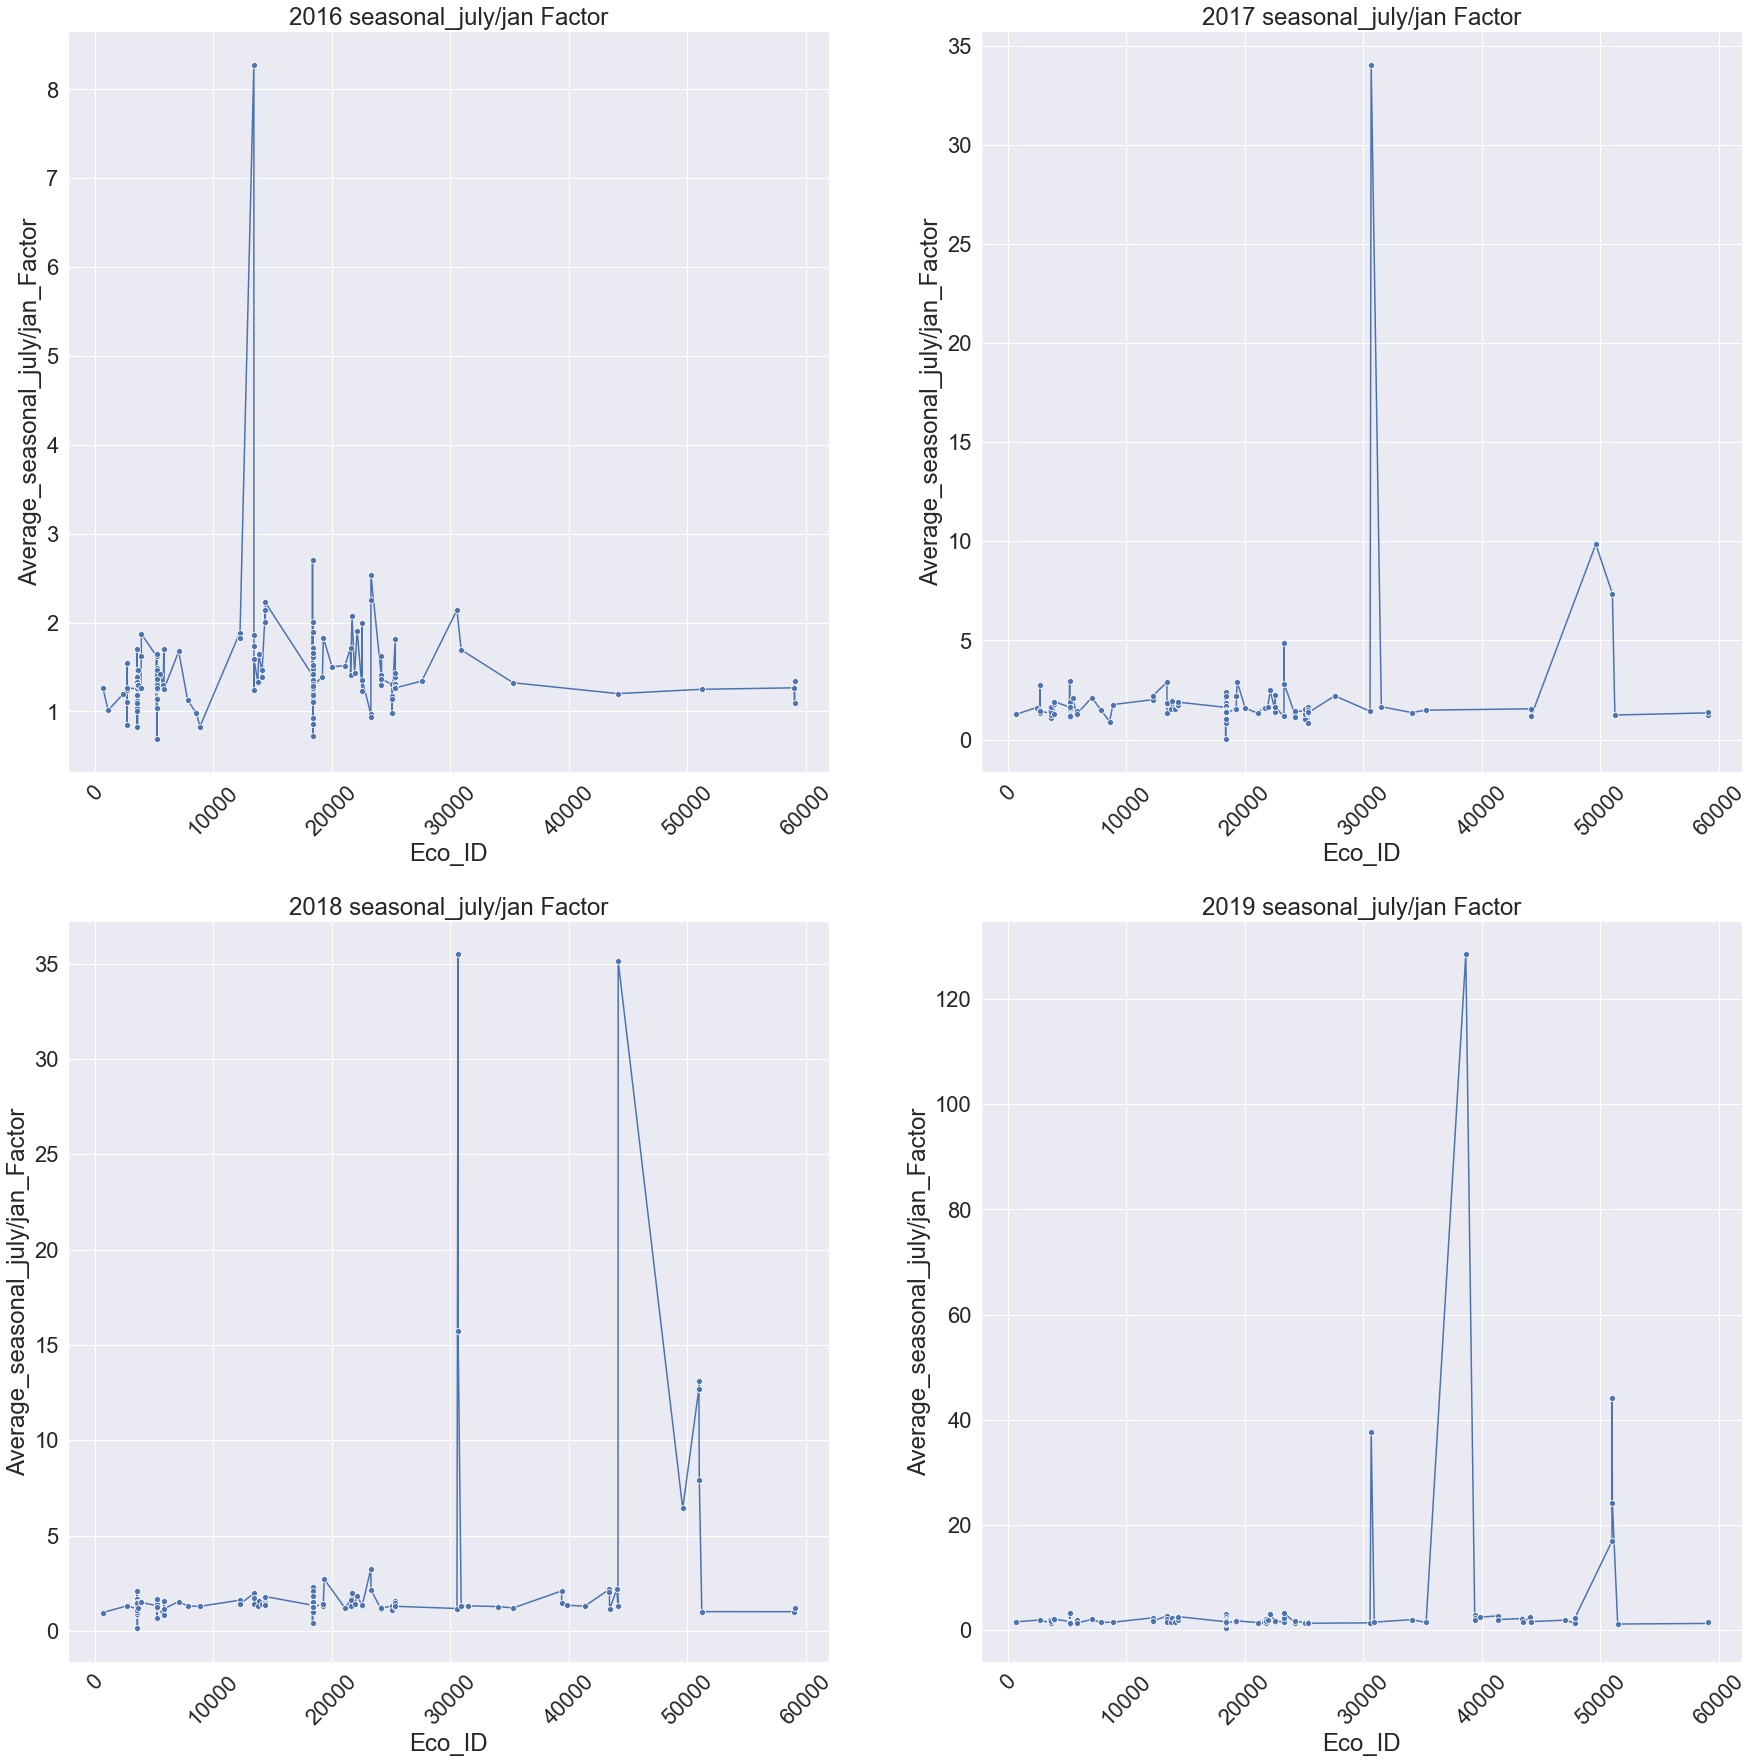

In [ ]:
#july_jan=seasonal_data.loc[seasonal_data['seasonal_factor']<11]
sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=2.0)
d16=seasonal_data.loc[seasonal_data['year']==2016]
d17=seasonal_data.loc[seasonal_data['year']==2017]
d18=seasonal_data.loc[seasonal_data['year']==2018]
d19=seasonal_data.loc[seasonal_data['year']==2019]




fig, ax = plt.subplots(2,2)

ax1 = sns.lineplot(x=d16['ID'],y=d16['seasonal_factor'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.lineplot(x=d17['ID'],y=d17['seasonal_factor'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.lineplot(x=d18['ID'],y=d18['seasonal_factor'],
                   markers=True,marker="o", dashes=False,sort=True,ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.lineplot(x=d19['ID'],y=d19['seasonal_factor'],
                   markers=True, marker="o", dashes=False,sort=True,ax=ax[1,1]) 
plt.xticks(rotation = 'vertical')
#ax1.get_legend().remove()
#ax2.get_legend().remove()
#ax3.get_legend().remove()
#ax4.get_legend().remove()
ax1.title.set_text('2016 seasonal_july/jan Factor')
ax2.title.set_text('2017 seasonal_july/jan Factor')
ax3.title.set_text('2018 seasonal_july/jan Factor')
ax4.title.set_text('2019 seasonal_july/jan Factor')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
ax1.set_ylabel('Average_seasonal_july/jan_Factor' )
ax1.set_xlabel('Eco_ID')
ax2.set_ylabel('Average_seasonal_july/jan_Factor' )
ax2.set_xlabel('Eco_ID')
ax3.set_ylabel('Average_seasonal_july/jan_Factor' )
ax3.set_xlabel('Eco_ID')
ax4.set_ylabel('Average_seasonal_july/jan_Factor' )
ax4.set_xlabel('Eco_ID')
plt.show()

In [115]:
# combine AMI_PMI_WWI and Seasonality
AAMI_PMI_WWI_WWI_Seasonal=pd.merge(AMI_PMI_WWI,seasonal_data,left_on=['ID','year'],right_on=['ID','year'],how='outer')
AAMI_PMI_WWI_WWI_Seasonal.head()

,ID,year,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,Daily_Max_AMI,...,Average PMI_wday_wend,Max_weekday_PMI,Max_weekend_PMI,max_daily_am_pm,max_daily_am_pm_value,max_weekend_am_pm,max_weekend_am_pm_Value,max_weekday_am_pm,max_weekday_am_pm_value,seasonal_factor
0,671,2016,2.23,0.77,0.70,0.32,2.17,0.36,0.93,0.93,...,2.21,1.23,0.49,PM,1.23,PMI,0.49,PMI,1.23,1.27
1,671,2017,2.89,0.78,0.74,0.38,1.97,0.44,1.02,1.02,...,2.07,1.21,0.49,PM,1.21,PMI,0.49,PMI,1.21,1.27
2,671,2018,1.35,0.71,0.86,0.29,2.97,0.30,1.43,1.43,...,2.73,1.30,0.39,AM,1.43,PMI,0.39,AMI,1.43,0.96
3,671,2019,1.44,0.66,0.82,0.34,2.41,0.35,1.21,1.21,...,2.56,1.13,0.42,AM,1.21,PMI,0.42,AMI,1.21,1.58
4,1127,2016,2.22,0.26,2.05,0.58,3.51,0.74,2.24,2.24,...,0.89,0.78,0.91,AM,2.24,PMI,0.91,AMI,2.24,1.01


In [116]:
AAMI_PMI_WWI_WWI_Seasonal.shape

(695, 23)

In [117]:
# add lat and long with location
# bring the lat and long of the counters
loc=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/Eco_combined_data_rural_vs_urban_before_QA_QC.csv')
loc=loc.rename(columns={'location_x':'location'})
loc1=loc[['ID','year','latitude','longitude','location']]
loc2=loc1.drop_duplicates(subset=['ID','latitude','longitude'], keep='first')
loc2=loc2.loc[loc['latitude']!=37.7792145070134]
loc2.shape

(417, 5)

In [118]:
# bring the location based on lat and long
def city_state_country(row):
    coord = f"{row['latitude']}, {row['longitude']}"
    sleep(1)
    location = geolocator.reverse(coord, exactly_one=True, language='en')
    if not location:
        # if you see many in a row, it's probably Nominatim blocking you.
        # if it's just every once in a while, there were just some bad results. 
        print('Failed with coord: ', coord)
        row['road'],row['city'],row['county'], row['state'], row['country'] = None, None, None
        return row
    address = location.raw['address']
    city = address.get('city', '')
    county=address.get('county', '')
    state = address.get('state', '')
    country = address.get('country', '')
    row['road']=address.get('road', '')
    row['city'] = city
    row['county'] = county
    row['state'] = state
    row['country'] = country
    return row

In [120]:
city_state1 = loc2.apply(city_state_country, axis=1)
city_state1.head()

,ID,year,latitude,longitude,location,road,city,county,state,country
0,671,2016,37.79,-122.46,urban,Bay Area Ridge Trail,San Francisco,,California,United States
35064,1127,2016,37.80,-122.42,urban,Broadway,San Francisco,,California,United States
70128,2415,2016,37.77,-122.44,urban,Fell Street,San Francisco,,California,United States
105192,2691,2016,35.29,-120.66,urban,Rail Road Safety Trail,San Luis Obispo,San Luis Obispo County,California,United States
140256,2692,2016,35.29,-120.66,urban,Rail Road Safety Trail,San Luis Obispo,San Luis Obispo County,California,United States


In [121]:
city_state1=city_state1.drop(['year'],axis=1)

In [122]:
AAMI_PMI_WWI_WWI_Seasonal1=pd.merge(AAMI_PMI_WWI_WWI_Seasonal,city_state1, left_on=['ID'], right_on=['ID'], how='inner')
AAMI_PMI_WWI_WWI_Seasonal1.head()

,ID,year,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,Daily_Max_AMI,...,max_weekday_am_pm_value,seasonal_factor,latitude,longitude,location,road,city,county,state,country
0,671,2016,2.23,0.77,0.70,0.32,2.17,0.36,0.93,0.93,...,1.23,1.27,37.79,-122.46,urban,Bay Area Ridge Trail,San Francisco,,California,United States
1,671,2017,2.89,0.78,0.74,0.38,1.97,0.44,1.02,1.02,...,1.21,1.27,37.79,-122.46,urban,Bay Area Ridge Trail,San Francisco,,California,United States
2,671,2018,1.35,0.71,0.86,0.29,2.97,0.30,1.43,1.43,...,1.43,0.96,37.79,-122.46,urban,Bay Area Ridge Trail,San Francisco,,California,United States
3,671,2019,1.44,0.66,0.82,0.34,2.41,0.35,1.21,1.21,...,1.21,1.58,37.79,-122.46,urban,Bay Area Ridge Trail,San Francisco,,California,United States
4,1127,2016,2.22,0.26,2.05,0.58,3.51,0.74,2.24,2.24,...,2.24,1.01,37.80,-122.42,urban,Broadway,San Francisco,,California,United States


In [123]:
AAMI_PMI_WWI_WWI_Seasonal1.shape

(695, 31)

In [124]:
check=AAMI_PMI_WWI_WWI_Seasonal1.loc[AAMI_PMI_WWI_WWI_Seasonal1['county']=='El Dorado County']
check.groupby(['year','county'])['ID'].count()

year  county          
2016  El Dorado County    2
2017  El Dorado County    5
2018  El Dorado County    7
2019  El Dorado County    8
Name: ID, dtype: int64

## SRR

The ratio of Strava annual recreational trips and Strava annual total trips is known as the Strava recreational ratio. The ratio varies from 0 to 1. The higher value of the recreational ratio indicates more recreational activities on that site. SRR was developed to separate the weekend HOD factor pattern

In [125]:
Strava=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/eco_stv_all.csv')
Strava.head()

,Unnamed: 0,ID,year,latitude,longitude,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio
0,0,671,2018,37.79,-122.46,308723101.00,215845474.00,4890.00,260.00,4630.00,0.05,0.95
1,1,1127,2018,37.80,-122.42,308779961.00,87297166.00,405.00,150.00,255.00,0.37,0.63
2,2,44181,2018,37.80,-122.42,308779961.00,87297166.00,405.00,150.00,255.00,0.37,0.63
3,3,2415,2018,37.77,-122.44,308725144.00,907910631.00,30655.00,11705.00,18950.00,0.38,0.62
4,4,44161,2018,37.77,-122.44,308725144.00,907910631.00,30655.00,11705.00,18950.00,0.38,0.62


In [135]:
Strava['ID'].nunique()

253

In [136]:
indices_strava=pd.merge(AAMI_PMI_WWI_WWI_Seasonal1,Strava,left_on=['ID','year','latitude','longitude'],right_on=['ID','year','latitude','longitude'],how='inner')
indices_strava.head()

,ID,year,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,Daily_Max_AMI,...,state,country,Unnamed: 0,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio
0,671,2016,2.23,0.77,0.70,0.32,2.17,0.36,0.93,0.93,...,California,United States,0,308723101.00,215845474.00,NaN,NaN,NaN,NaN,NaN
1,671,2017,2.89,0.78,0.74,0.38,1.97,0.44,1.02,1.02,...,California,United States,0,308723101.00,215845474.00,NaN,NaN,NaN,NaN,NaN
2,671,2018,1.35,0.71,0.86,0.29,2.97,0.30,1.43,1.43,...,California,United States,0,308723101.00,215845474.00,4890.00,260.00,4630.00,0.05,0.95
3,671,2019,1.44,0.66,0.82,0.34,2.41,0.35,1.21,1.21,...,California,United States,0,308723101.00,215845474.00,4625.00,255.00,4370.00,0.06,0.94
4,1127,2016,2.22,0.26,2.05,0.58,3.51,0.74,2.24,2.24,...,California,United States,1,308779961.00,87297166.00,NaN,NaN,NaN,NaN,NaN


In [137]:
indices_strava.shape

(588, 39)

In [138]:
indices_strava.groupby(['year'])['ID'].count()

year
2016    154
2017    150
2018    148
2019    136
Name: ID, dtype: int64

In [139]:
# save all indices
indices_strava.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/Updated_indices.csv')

# Calculate indices short term counters

In [ ]:
sc_data_all_4=pd.read_csv('D:/Bike_ped Exposure Model Project/Processed Data/short_term_clean_data_2016_2019.csv')

## AMI

In [ ]:
# separate the data that supporting data to assign travel pattern
sc_data_all11=sc_data_all_4[(sc_data_all_4['starttime']=="07:00:00") & (sc_data_all_4['endtime']=="08:00:00")]
sc_data_all12=sc_data_all_4[(sc_data_all_4['starttime']=="08:00:00") & (sc_data_all_4['endtime']=="09:00:00")]
sc_data_all1=pd.concat([sc_data_all11,sc_data_all12],axis=0)
sc_data_all1amg=pd.DataFrame({'AM_count' : sc_data_all1.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

sc_data_all22=sc_data_all_4[(sc_data_all_4['starttime']=="11:00:00") & (sc_data_all_4['endtime']=="12:00:00")]
sc_data_all23=sc_data_all_4[(sc_data_all_4['starttime']=="12:00:00") & (sc_data_all_4['endtime']=="13:00:00")]
sc_data_all2=pd.concat([sc_data_all22,sc_data_all23],axis=0)
sc_data_all2pmg=pd.DataFrame({'AMPM_count' : sc_data_all2.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

sc_data_all33=sc_data_all_4[(sc_data_all_4['starttime']=="17:00:00") & (sc_data_all_4['endtime']=="18:00:00")]
sc_data_all34=sc_data_all_4[(sc_data_all_4['starttime']=="18:00:00") & (sc_data_all_4['endtime']=="19:00:00")]
sc_data_all3=pd.concat([sc_data_all33,sc_data_all34],axis=0)
sc_data_all3amg=pd.DataFrame({'PM_count' : sc_data_all3.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

# Join am and Pm count by eco id
sc_data_all_am_ampm=pd.merge(sc_data_all1amg,sc_data_all2pmg,left_on=["ID",'Leg','year'],right_on=["ID",'Leg','year'],how='inner')
# Calculate the AMI
sc_data_all_am_ampm['AMI']=sc_data_all_am_ampm['AM_count']/sc_data_all_am_ampm['AMPM_count']
sc_data_all_am_ampm.head()

In [ ]:
sc_data_all_am_ampm.groupby(['Leg','year'])['ID'].count()

In [73]:
sc_data_all_4.groupby(['Leg','year'])['ID'].count()

Leg  year   
E    2016.00    2685
     2017.00    1158
     2018.00    2031
     2019.00    1334
N    2016.00    2721
     2017.00    1442
     2018.00    1822
     2019.00    1147
NE   2018.00       3
NW   2018.00       4
S    2016.00    2610
     2017.00    1588
     2018.00    1886
     2019.00    1317
W    2016.00    2421
     2017.00    1052
     2018.00    1501
     2019.00    1189
Name: ID, dtype: int64

## PMI

In [74]:
# Join ampm and Pm count by eco id
sc_data_all_pm_ampm=pd.merge(sc_data_all3amg,sc_data_all2pmg,left_on=["ID",'Leg','year'],right_on=["ID",'Leg','year'],how='inner')
# Calculate the PMI
sc_data_all_pm_ampm['PMI']=sc_data_all_pm_ampm['PM_count']/sc_data_all_pm_ampm['AMPM_count']
sc_data_all_pm_ampm.head()

,ID,Leg,year,PM_count,AMPM_count,PMI
0,AC20160,E,2016.00,7,2,3.50
1,AC20160,N,2016.00,4,4,1.00
2,AC20160,S,2016.00,8,3,2.67
3,AC20160,W,2016.00,13,5,2.60
4,AC201610,E,2016.00,22,7,3.14


In [75]:
sc_data_all_pm_ampm.groupby(['Leg','year'])['ID'].count()

Leg  year   
E    2016.00    76
     2017.00    41
     2018.00    88
     2019.00    89
N    2016.00    80
     2017.00    66
     2018.00    80
     2019.00    73
NW   2018.00     1
S    2016.00    75
     2017.00    49
     2018.00    82
     2019.00    69
W    2016.00    67
     2017.00    39
     2018.00    66
     2019.00    85
Name: ID, dtype: int64

In [76]:
sh_ami_pmi=pd.merge(sc_data_all_am_ampm,sc_data_all_pm_ampm,left_on=['ID','Leg','year'],right_on=['ID','Leg','year'], how='outer')
sh_ami_pmi['am_pm_ratio']=sh_ami_pmi['AMI']/sh_ami_pmi['PMI']
sh_ami_pmi.head()

,ID,Leg,year,AM_count,AMPM_count_x,AMI,PM_count,AMPM_count_y,PMI,am_pm_ratio
0,CH11,E,2019.00,4.00,2.00,2.00,4.00,2.00,2.00,1.00
1,CH11,W,2019.00,4.00,1.00,4.00,2.00,1.00,2.00,2.00
2,CH13,E,2019.00,7.00,1.00,7.00,1.00,1.00,1.00,7.00
3,CH13,W,2019.00,7.00,1.00,7.00,1.00,1.00,1.00,7.00
4,CH15,E,2019.00,7.00,5.00,1.40,2.00,5.00,0.40,3.50


In [77]:
# Count both and AMI and PMI Presence
am_pm_check=sh_ami_pmi.loc[sh_ami_pmi['am_pm_ratio']>=0]

In [78]:
# count that have both AMI and PMI
am_pm_check.groupby(['Leg','year'])['ID'].count()

Leg  year   
E    2016.00    56
     2017.00    24
     2018.00    59
     2019.00    81
N    2016.00    50
     2017.00    55
     2018.00    54
     2019.00    66
S    2016.00    48
     2017.00    40
     2018.00    54
     2019.00    62
W    2016.00    45
     2017.00    24
     2018.00    37
     2019.00    72
Name: ID, dtype: int64

# WWI

In [79]:
# Calculate weekend Count by eco id
sc_data_all_weekend=sc_data_all_4.loc[sc_data_all_4['weekday_Status']==1]
sc_data_all_weekendg=pd.DataFrame({'Weekend_count' : sc_data_all_weekend.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

# Calculate weekday count by Eco ID
sc_data_all_weeekday=sc_data_all_4.loc[sc_data_all_4['weekday_Status']==0]
sc_data_all_weekdayg=pd.DataFrame({'Weekday_count' : sc_data_all_weeekday.groupby(['ID','Leg','year'])['Count'].sum()}).reset_index()

# Join weekend and weekday count by eco id
sc_data_all_weekend_weekday=pd.merge(sc_data_all_weekendg,sc_data_all_weekdayg,left_on=["ID",'Leg','year'],right_on=["ID",'Leg','year'],how='inner')
# Calculate the WWI
sc_data_all_weekend_weekday['WWI']=sc_data_all_weekend_weekday['Weekend_count']/sc_data_all_weekend_weekday['Weekday_count']
sc_data_all_weekend_weekday

,ID,Leg,year,Weekend_count,Weekday_count,WWI
0,Los_Gatos0,E,2016.00,39,22,1.77
1,Los_Gatos0,N,2016.00,65,26,2.50
2,Los_Gatos0,S,2016.00,89,22,4.05
3,Los_Gatos0,W,2016.00,0,0,NaN
4,Los_Gatos1,E,2016.00,73,50,1.46
5,Los_Gatos1,N,2016.00,49,21,2.33
6,Los_Gatos1,S,2016.00,8,8,1.00
7,Los_Gatos1,W,2016.00,26,14,1.86
8,Los_Gatos2,E,2016.00,17,69,0.25
9,Los_Gatos2,N,2016.00,16,68,0.24


In [ ]:
# end of the Code